### Running through some examples discussed in the lectures with python

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

### Cross Fitting

In [74]:
def cross_fit_predict(model, X, y, pred_batch_size = 1, binary_model = False):
    """Takes a prediction model and iteratively cross fit on training data with prediction batch left out.
    Deterministic ordering ; assume that training data has already been shuffled randomly."""
    n_batch = int(np.ceil(len(X) / pred_batch_size))
    preds = []
    for n in range(n_batch) : 
        X_pred = X[n * pred_batch_size : n * pred_batch_size + pred_batch_size]
        X_train = np.append(X[0 : n * pred_batch_size], X[n * pred_batch_size + pred_batch_size ::], axis = 0)
        y_train = np.append(y[0 : n * pred_batch_size], y[n * pred_batch_size + pred_batch_size ::])
        model.fit(X_train, y_train)
        if binary_model:
            preds.extend(model.predict_proba(X_pred)[:,1].reshape(-1))
        else:
            preds.extend(model.predict(X_pred).reshape(-1))
    return preds

# ATE - Constant Treatment Effect

In [120]:
def potential_outcome(xi, ti):
    return ti * (np.abs((xi[0] + xi[1])) - .05)  + (1 - ti) * np.abs((xi[0] + xi[2])) 

##### Constant propensity score

In [5]:
#Constant propensity score
n_sim = 50000
X = np.random.randn(n_sim,3)
T = np.random.binomial(1, .5, size = n_sim)
outcomes = np.array([potential_outcome(xi, ti) for xi,ti in zip(X, T)])
print(np.mean(outcomes[np.argwhere(T == 1).reshape(-1)]) - np.mean(outcomes[np.argwhere(T == 0).reshape(-1)]))

-0.05932054601752923


#### Covariate-dependent propensity score

In [122]:
def propensity_score(X):
    return 1 / (1 + np.exp(-X[:,0]))

## AIPW 
tau_est = R + D

### 1) (R) Regression adjustment estimator

R = $\dfrac{1}{n}\sum_i{(\hat{u_{1i}} - \hat{u_{0i}})}$ <br>
where the $\hat{u_i}$ are fit by cross fitting (the estimator used to predict outcome for a sample was not trained on that sample)


In [82]:
#With confounding
n_sim = 1000
p = 20
X = np.random.randn(n_sim,p)
T = np.random.binomial(1, propensity_score(X))
outcomes = np.array([potential_outcome(xi, ti) for xi,ti in zip(X, T)])
df = pd.DataFrame(columns = [f"x{i}" for i in range(p)], data = X)
df['T'] = T
df['Y'] = outcomes
### random forest for separate potential outcomes u_1(X) and u_2(X)
##out-of-the-box random forest model
for t in [0, 1]:
    mask_t = df['T'] == t
    preds = cross_fit_predict(RandomForestRegressor(),
                              X = df.loc[mask_t].values[:,0:p],
                              y = df.loc[mask_t].Y.values,
                              pred_batch_size = 50)
    df.loc[mask_t, f'mu_hat{t}'] = preds
    X_unobs = df.loc[~mask_t].values[:, 0:p]
    preds_unobs = (RandomForestRegressor().
                         fit(X = df.loc[mask_t].values[:,0:p], y = df.loc[mask_t].Y.values).
                         predict(X_unobs).reshape(-1))
    df.loc[~mask_t, f'mu_hat{t}'] = preds_unobs
        

In [83]:
np.mean(df.mu_hat1 - df.mu_hat0)

-0.04146168805792007

### 2) (D) Add in IPW applied to residuals

D = $\dfrac{1}{n}\sum_i{\bigg(\big(\dfrac{w_i}{\hat{e_i}}\big)\big(y_i - \hat{u_{1i}}\big) - \big(\dfrac{1 - w_i}{1 - \hat{e_i}}\big)\big(y_i - \hat{u_{0i}}\big)\bigg)}$
<br><br>
where $w_i$ is the treatment indicator for the sample i and $\hat{e_i}$ is the propensity score for that sample as estimated by cross fitting.  So depending if $w_i = 1$ or $w_i = 0$, one or the other propensity-score-weighted residuals terms in the summation will be nonzero and one will be zero

##### Propensity score estimator

In [104]:
ehat_preds = cross_fit_predict(RandomForestClassifier(), X = X, y = T, binary_model = True,
                         pred_batch_size = 50)
df['ehat_pred'] = ehat_preds

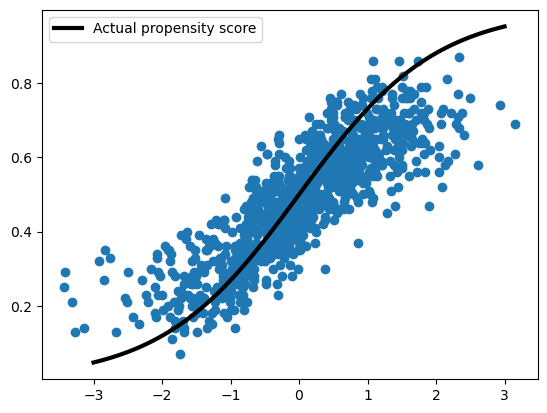

In [95]:
fig,ax = plt.subplots()
ax.scatter(X[:,0], ehat_preds)
xp = np.linspace(-3, 3, 100)
ax.plot(xp, propensity_score(xp.reshape(-1,1)),color = 'k',linewidth = 3, label = 'Actual propensity score')
ax.legend()

In [107]:
def resid_ipw(x):
    return ((x['T']/x['ehat_pred']) * (x['Y'] - x['mu_hat1'])) - (((1 - x['T'])/(1 - x['ehat_pred'])) * (x['Y'] - x['mu_hat0']))
df['R'] = df.apply(lambda x : resid_ipw(x), axis = 1)

### 3) R + D = Final AIPW estimator for ATE
(compare to actual of -.05)

In [117]:
df['taui_aipw'] = (df['mu_hat1'] - df['mu_hat0'] + df['R'])
tau_aipw = np.mean(df['taui_aipw'])
tau_aipw

-0.05170306472513528

In [118]:
var_aipw = 1/(np.sqrt(n_sim * (n_sim - 1))) * np.sqrt(np.sum((df['taui_aipw'] - tau_aipw)**2))
var_aipw

0.03759314301977968

## Residual - on - Residual Regression (Robinsons method)
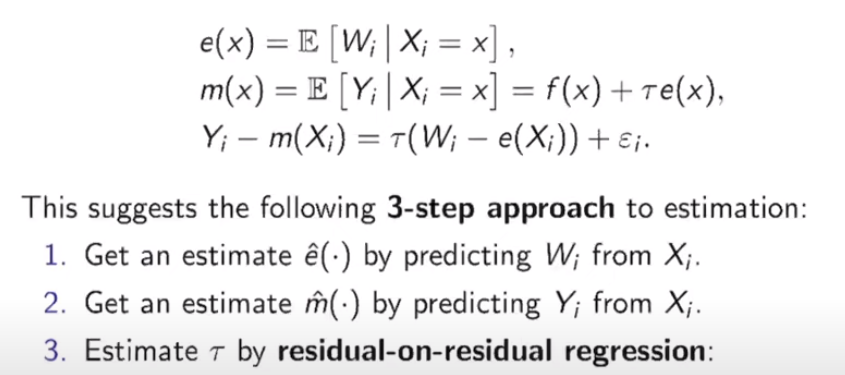
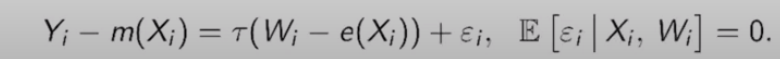